Financials columns: Index(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs',
       'Normalized EBITDA',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA',
       'EBIT', 'Net Interest Income', 'Interest Expense', 'Interest Income',
       'Normalized Income',
       'Net Income From Continuing And Discontinued Operation',
       'Total Expenses', 'Total Operating Income As Reported',
       'Diluted Average Shares', 'Basic Average Shares', 'Diluted EPS',
       'Basic EPS', 'Diluted NI Availto Com Stockholders',
       'Net Income Common Stockholders', 'Otherunder Preferred Stock Dividend',
       'Net Income', 'Minority Interests',
       'Net Income Including Noncontrolling Interests',
       'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income',
       'Other Non Operating Income Expenses',
       'Net Non Operating Interest Income Expense',
       'Interest Expense Non Ope

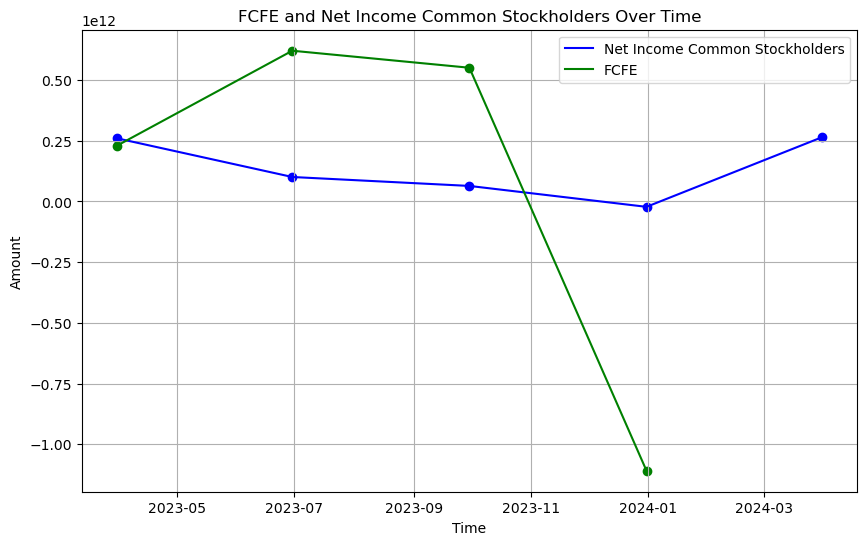

In [18]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# List of tickers
tickers = ["DPM.VN"]

def fetch_financial_data_from_2010(ticker):
    # Fetch data from Yahoo Finance
    stock = yf.Ticker(ticker)
    
    # Fetch annual financials
    financials = stock.quarterly_financials.T
    balance_sheet = stock.quarterly_balance_sheet.T
    cash_flow = stock.quarterly_cashflow.T
    
    # Function to filter and convert index to datetime
    def filter_dates(df):
        df = df.copy()
        try:
            df.index = pd.to_datetime(df.index, errors='coerce')
            df = df[df.index.notna()]
            df = df[df.index >= '2010-01-01']
        except Exception as e:
            print(f"Error converting dates for {ticker}: {e}")
        return df
    
    # Filter data 
    financials = filter_dates(financials)
    balance_sheet = filter_dates(balance_sheet)
    cash_flow = filter_dates(cash_flow)

    return financials, balance_sheet, cash_flow

def calculate_fcfe(financials, cash_flow, balance_sheet):
    import pandas as pd

    # Helper function to get data or return a series of zeros if not found
    def get_data(dataframe, key, index):
        return dataframe.get(key, pd.Series(0, index=index))
    
    # Index for default Series creation
    index = financials.index if not financials.empty else (cash_flow.index if not cash_flow.empty else balance_sheet.index)

    # Get Net Income from the income statement
    net_income = get_data(financials, 'Net Income Common Stockholders', index)
    
    # Get Depreciation and Amortization (D&A) from the cash flow statement
    depreciation_amortization = get_data(financials, 'Reconciled Depreciation', index)
    
    # Calculate Net Working Capital
    current_assets = get_data(balance_sheet, 'Current Assets', index)
    cash_and_equivalents = get_data(balance_sheet, 'Cash Cash Equivalents And Short Term Investments', index)
    current_liabilities = get_data(balance_sheet, 'Current Liabilities', index)
    
    net_working_capital = current_assets - cash_and_equivalents - current_liabilities
    change_in_nwc =  net_working_capital.shift(1).fillna(0)-net_working_capital 
    change_in_nwc = change_in_nwc.shift(-1).fillna(0)
    # Print change in NWC for debugging
    print("Change in NWC:\n", change_in_nwc)
    
    
    # Get Capital Expenditures (Capex) from the cash flow statement
    capex = get_data(cash_flow, 'Capital Expenditure', index)
    
    # Get Net Borrowing (issuance of debt + repayment of debt) from the cash flow statement
    issuance_of_debt = get_data(cash_flow, 'Issuance Of Debt', index)
    repayment_of_debt = cash_flow.get('Repayment Of Debt', pd.Series(0, index=index))  # Ensure repayment_of_debt is 0 if not found
    net_borrowing = issuance_of_debt + repayment_of_debt
    
    # Calculate FCFE
    fcfe = net_income + depreciation_amortization   + net_borrowing +capex -change_in_nwc
    
    # Update FCFE column in balance sheet
    balance_sheet['FCFE'] = fcfe
    
    return balance_sheet



import pandas as pd

def calculate_dupont_analysis(financials, balance_sheet):
    # Print columns to check names
    print("Financials columns:", financials.columns)
    print("Balance Sheet columns:", balance_sheet.columns)
    
    # Ensure required columns exist and convert to float
    # Adjust column names based on the actual data
    if 'Net Income Common Stockholders' in financials.columns:
        financials['Net Income'] = financials['Net Income Common Stockholders'].astype(float)
    elif 'Net Income Applicable to Common Shares' in financials.columns:
        financials['Net Income'] = financials['Net Income Applicable to Common Shares'].astype(float)
    else:
        print("Error: 'Net Income Common Stockholders' or 'Net Income Applicable to Common Shares' column not found in financials")
        return None
    
    if 'Total Revenue' in financials.columns:
        financials['Total Revenue'] = financials['Total Revenue'].astype(float)
    elif 'Revenues' in financials.columns:
        financials['Total Revenue'] = financials['Revenues'].astype(float)
    else:
        print("Error: 'Total Revenue' or 'Revenues' column not found in financials")
        return None
    
    if 'Total Assets' in balance_sheet.columns:
        balance_sheet['Total Assets'] = balance_sheet['Total Assets'].astype(float)
    elif 'Assets' in balance_sheet.columns:
        balance_sheet['Total Assets'] = balance_sheet['Assets'].astype(float)
    else:
        print("Error: 'Total Assets' or 'Assets' column not found in balance sheet")
        return None
    
    if 'Total Equity Gross Minority Interest' in balance_sheet.columns:
        balance_sheet['Total Equity'] = balance_sheet['Total Equity Gross Minority Interest'].astype(float)
    elif 'Common Stock Equity' in balance_sheet.columns:
        balance_sheet['Total Equity'] = balance_sheet['Common Stock Equity'].astype(float)
    else:
        print("Error: 'Total Equity Gross Minority Interest' or 'Common Stock Equity' column not found in balance sheet")
        return None

    
    # Calculate Dupont components
    profit_margin = financials['Net Income'] / financials['Total Revenue']
    # Adjusted for Total Assets - Cash Cash Equivalents And Short Term Investments
    asset_turnover = financials['Total Revenue'] / (balance_sheet['Total Assets'] - balance_sheet['Cash Cash Equivalents And Short Term Investments'])
    equity_multiplier = (balance_sheet['Total Assets'] - balance_sheet['Cash Cash Equivalents And Short Term Investments']) / balance_sheet['Total Equity']
    
    # Calculate ROE using Dupont formula
    roe_dupont = profit_margin * asset_turnover * equity_multiplier
    
    # Combine results into a DataFrame
    dupont_analysis = pd.DataFrame({
        'Profit Margin': profit_margin,
        'Asset Turnover': asset_turnover,
        'Equity Multiplier': equity_multiplier,
        'ROE (Dupont)': roe_dupont
    })
    
    return dupont_analysis

if __name__ == "__main__":
    for ticker in tickers:
        financials, balance_sheet, cash_flow = fetch_financial_data_from_2010(ticker)
        
        # Perform Dupont analysis
        dupont_results = calculate_dupont_analysis(financials, balance_sheet)
        
        if dupont_results is not None:
            # Reverse the order of rows in the DataFrame
            dupont_results = dupont_results.iloc[::-1]
            
            # Calculate FCFE
            balance_sheet = calculate_fcfe(financials, cash_flow, balance_sheet)
            
            # Calculate FCFE/equity ratio
            balance_sheet['FCFE/Equity'] = balance_sheet['FCFE'] / balance_sheet['Total Equity Gross Minority Interest']
            
            # Add FCFE/Equity ratio to Dupont analysis DataFrame
            dupont_results['FCFE/Equity'] = balance_sheet['FCFE/Equity']
            
            # Print the financial data and Dupont analysis
            print(f"\nFinancials for {ticker} :")
            print(financials)
            print(f"\nBalance Sheet for {ticker} :")
            print(balance_sheet)
            print(f"\nCash Flow for {ticker} :")
            print(cash_flow)
            print(f"\nDupont Analysis for {ticker} :")
            print(dupont_results)
            
        else:
            print(f"Skipping Dupont analysis for {ticker} due to missing data.")
if __name__ == "__main__":
    for ticker in tickers:
        financials, balance_sheet, cash_flow = fetch_financial_data_from_2010(ticker)
        
        # Perform Dupont analysis
        dupont_results = calculate_dupont_analysis(financials, balance_sheet)
        
        if dupont_results is not None:
            # Reverse the order of rows in the DataFrame
            dupont_results = dupont_results.iloc[::-1]
            
            # Calculate FCFE
            balance_sheet = calculate_fcfe(financials, cash_flow, balance_sheet)
            
            # Merge financials and balance_sheet on the index
            merged_df = pd.merge(financials, balance_sheet[['FCFE']], left_index=True, right_index=True, how='left')
            
            # Plot FCFE and Net Income Common Stockholders
            plt.figure(figsize=(10, 6))
            plt.plot(merged_df.index, merged_df['Net Income Common Stockholders'], label='Net Income Common Stockholders', color='blue')
            plt.scatter(merged_df.index, merged_df['Net Income Common Stockholders'], color='blue', marker='o')
            plt.plot(merged_df.index, merged_df['FCFE'], label='FCFE', color='green')
            plt.scatter(merged_df.index, merged_df['FCFE'], color='green', marker='o')
            plt.xlabel('Time')
            plt.ylabel('Amount')
            plt.title('FCFE and Net Income Common Stockholders Over Time')
            plt.legend()
            plt.grid(True)
            plt.show()
            
        else:
            print(f"Skipping Dupont analysis for {ticker} due to missing data.")

Financials columns: Index(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs',
       'Normalized EBITDA',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA',
       'EBIT', 'Net Interest Income', 'Interest Expense', 'Interest Income',
       'Normalized Income',
       'Net Income From Continuing And Discontinued Operation',
       'Total Expenses', 'Total Operating Income As Reported',
       'Diluted Average Shares', 'Basic Average Shares', 'Diluted EPS',
       'Basic EPS', 'Diluted NI Availto Com Stockholders',
       'Net Income Common Stockholders', 'Otherunder Preferred Stock Dividend',
       'Net Income', 'Minority Interests',
       'Net Income Including Noncontrolling Interests',
       'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income',
       'Other Non Operating Income Expenses',
       'Net Non Operating Interest Income Expense',
       'Interest Expense Non Ope

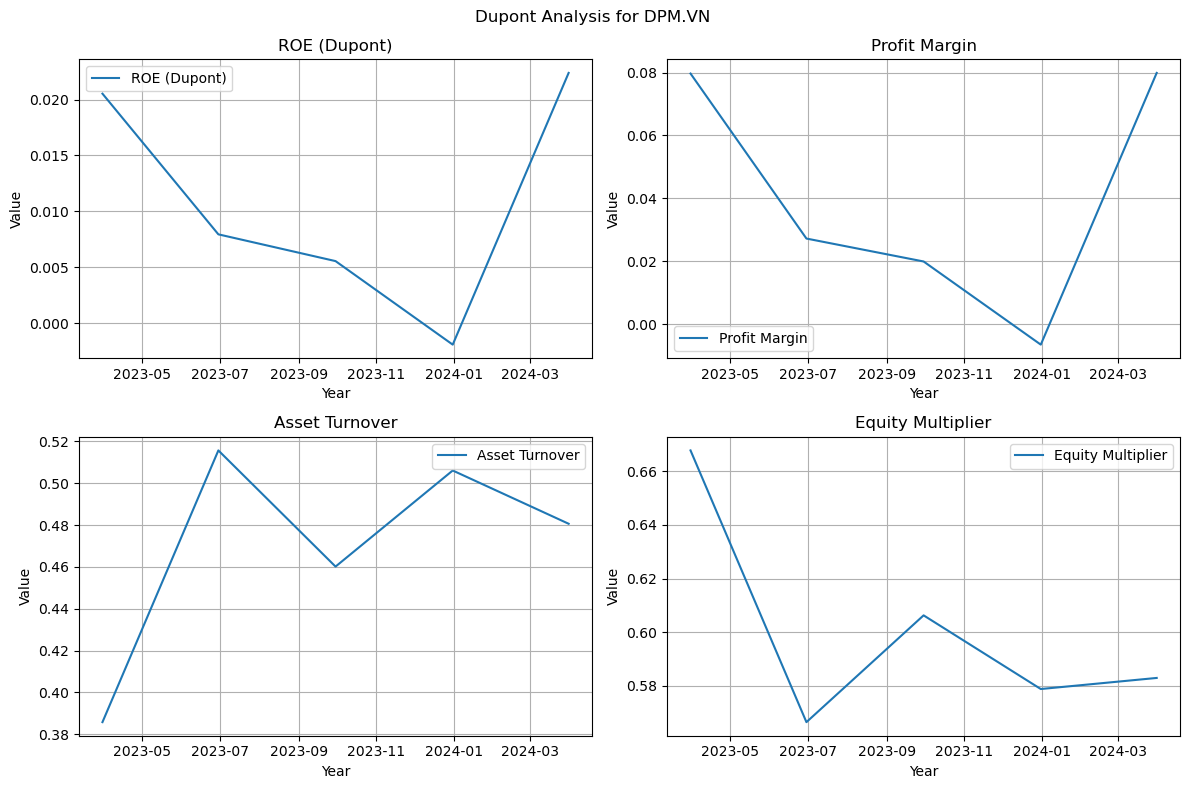

In [19]:


def plot_dupont_analysis(ticker, dupont_results):
    # Plot ROE, profit margin, asset turnover, and equity multiplier
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'Dupont Analysis for {ticker} ')

    axs[0, 0].plot(dupont_results.index, dupont_results['ROE (Dupont)'], label='ROE (Dupont)')
    axs[0, 0].set_title('ROE (Dupont)')

    axs[0, 1].plot(dupont_results.index, dupont_results['Profit Margin'], label='Profit Margin')
    axs[0, 1].set_title('Profit Margin')

    axs[1, 0].plot(dupont_results.index, dupont_results['Asset Turnover'], label='Asset Turnover')
    axs[1, 0].set_title('Asset Turnover')

    axs[1, 1].plot(dupont_results.index, dupont_results['Equity Multiplier'], label='Equity Multiplier')
    axs[1, 1].set_title('Equity Multiplier')

    # Add labels and legend
    for ax in axs.flat:
        ax.set(xlabel='Year', ylabel='Value')
        ax.grid()
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
   

    for ticker in tickers:
        financials, balance_sheet, cash_flow = fetch_financial_data_from_2010(ticker)
        
        # Perform Dupont analysis
        dupont_results = calculate_dupont_analysis(financials, balance_sheet)
        
        # Plot Dupont analysis
        plot_dupont_analysis(ticker, dupont_results)

In [20]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame()

for ticker in tickers:
    financials, balance_sheet, _ = fetch_financial_data_from_2010(ticker)
    
    # Perform Dupont analysis
    dupont_results = calculate_dupont_analysis(financials, balance_sheet)
    
    # Calculate percentage changes compared to previous year
    for col in ['Profit Margin', 'Asset Turnover', 'Equity Multiplier', 'ROE (Dupont)']:
        dupont_results[f'{col} Change'] = dupont_results[col].pct_change().shift(-1) * 100
    
    # Add ticker as a column
    dupont_results['Ticker'] = ticker
    
    # Concatenate results to the main DataFrame
    results_df = pd.concat([results_df, dupont_results], axis=0)
# Sort the DataFrame by the index (Year)
results_df = results_df.sort_index()
# Reset index
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Year'}, inplace=True)

# Reverse the order of columns
results_df = results_df.iloc[:, ::-1]
results_df.dropna(inplace=True)

print(results_df)








Financials columns: Index(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs',
       'Normalized EBITDA',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA',
       'EBIT', 'Net Interest Income', 'Interest Expense', 'Interest Income',
       'Normalized Income',
       'Net Income From Continuing And Discontinued Operation',
       'Total Expenses', 'Total Operating Income As Reported',
       'Diluted Average Shares', 'Basic Average Shares', 'Diluted EPS',
       'Basic EPS', 'Diluted NI Availto Com Stockholders',
       'Net Income Common Stockholders', 'Otherunder Preferred Stock Dividend',
       'Net Income', 'Minority Interests',
       'Net Income Including Noncontrolling Interests',
       'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income',
       'Other Non Operating Income Expenses',
       'Net Non Operating Interest Income Expense',
       'Interest Expense Non Ope

Financials columns: Index(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs',
       'Normalized EBITDA',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA',
       'EBIT', 'Net Interest Income', 'Interest Expense', 'Interest Income',
       'Normalized Income',
       'Net Income From Continuing And Discontinued Operation',
       'Total Expenses', 'Total Operating Income As Reported',
       'Diluted Average Shares', 'Basic Average Shares', 'Diluted EPS',
       'Basic EPS', 'Diluted NI Availto Com Stockholders',
       'Net Income Common Stockholders', 'Otherunder Preferred Stock Dividend',
       'Net Income', 'Minority Interests',
       'Net Income Including Noncontrolling Interests',
       'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income',
       'Other Non Operating Income Expenses',
       'Net Non Operating Interest Income Expense',
       'Interest Expense Non Ope

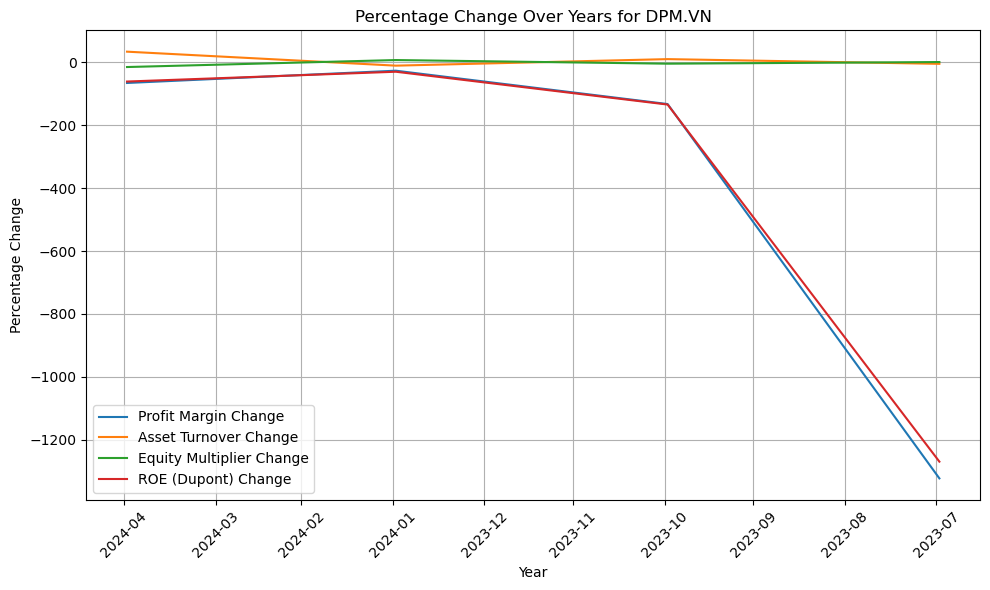

In [21]:
def plot_percentage_changes(results_df):
    tickers = results_df['Ticker'].unique()
    
    for ticker in tickers:
        ticker_data = results_df[results_df['Ticker'] == ticker]
        
        plt.figure(figsize=(10, 6))
        
        for col in ['Profit Margin Change', 'Asset Turnover Change', 'Equity Multiplier Change', 'ROE (Dupont) Change']:
            # Reverse the order of x-axis values for all tickers
            x_values = ticker_data['Year'][::-1]
            y_values = ticker_data[col]
            plt.plot(x_values, y_values, label=col)
        
        plt.title(f'Percentage Change Over Years for {ticker}')
        plt.xlabel('Year')
        plt.ylabel('Percentage Change')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.tight_layout()
        plt.gca().invert_xaxis()  # Invert x-axis
        plt.show()

if __name__ == "__main__":
    # Create an empty DataFrame to store the results
    results_df = pd.DataFrame()

    for ticker in tickers:
        financials, balance_sheet, _ = fetch_financial_data_from_2010(ticker)
        
        # Perform Dupont analysis
        dupont_results = calculate_dupont_analysis(financials, balance_sheet)
        
        # Calculate percentage changes compared to the previous row
        for col in ['Profit Margin', 'Asset Turnover', 'Equity Multiplier', 'ROE (Dupont)']:
            dupont_results[f'{col} Change'] = dupont_results[col].pct_change() * 100
        
        # Add ticker as a column
        dupont_results['Ticker'] = ticker
        
        # Concatenate results to the main DataFrame
        results_df = pd.concat([results_df, dupont_results], axis=0)

    # Reset index
    results_df.reset_index(inplace=True)
    results_df.rename(columns={'index': 'Year'}, inplace=True)

    # Drop rows with NaN values
    results_df.dropna(inplace=True)

    # Plot percentage changes
    plot_percentage_changes(results_df)

In [22]:
def compare_fcfe_and_ratio(financials, cash_flow, balance_sheet, ticker):
    # Tính tỷ lệ FCFE / Equity nếu chưa có
    if 'FCFE' not in balance_sheet.columns:
        balance_sheet = calculate_fcfe(financials, cash_flow, balance_sheet)
        balance_sheet['FCFE/Equity'] = balance_sheet['FCFE'] / balance_sheet['Total Equity Gross Minority Interest']
    
    # Kiểm tra sự tồn tại của các cột và tính toán
    try:
        depreciation = financials['Reconciled Depreciation']
    except KeyError:
        print(f"Reconciled Depreciation data not found for {ticker}")
        depreciation = pd.Series(0, index=financials.index)
    
    try:
        net_income = financials['Net Income Common Stockholders']
    except KeyError:
        print(f"Net Income data not found for {ticker}")
        net_income = pd.Series(0, index=financials.index)
    
    try:
        issuance_of_debt = cash_flow['Issuance Of Debt']
    except KeyError:
        print(f"Issuance of Debt data not found for {ticker}")
        issuance_of_debt = pd.Series(0, index=cash_flow.index)
    
    try:
        repayment_of_debt = cash_flow['Repayment Of Debt']
    except KeyError:
        print(f"Repayment of Debt data not found for {ticker}")
        repayment_of_debt = pd.Series(0, index=cash_flow.index)
    
    net_borrowing = issuance_of_debt + repayment_of_debt
    
    ratio_2 = (depreciation + net_income + net_borrowing) / balance_sheet['Total Equity Gross Minority Interest']
    
    # Kết hợp kết quả vào DataFrame
    comparison_df = pd.DataFrame({
        'FCFE/Equity': balance_sheet['FCFE/Equity'],
        '(Reconciled Depreciation + Return + Net borrowing) / Equity': ratio_2
    })
    
    # So sánh và in kết quả, thêm cột kết quả so sánh vào DataFrame
    comparison_results = []
    for date in comparison_df.index:
        fcfe_equity = comparison_df.loc[date, 'FCFE/Equity']
        ratio_2_value = comparison_df.loc[date, '(Reconciled Depreciation + Return + Net borrowing) / Equity']
        
        if fcfe_equity > ratio_2_value:
            comparison_results.append("(1) > (2) : Doanh nghiệp đang bán tài sản hoặc thu được tiền từ working capital")
        elif fcfe_equity < ratio_2_value:
            comparison_result = "(1) < (2) : Doanh nghiệp đang mua thêm tài sản hoặc đầu tư tiền vào working capital"
            if 0 < fcfe_equity < ratio_2_value:
                comparison_result += " | TH1 - 0 < (1) < (2): Doanh nghiệp không phải dùng tiền và chứng khoán tích luỹ từ các kỳ trước để đầu tư vào tài sản"
            elif fcfe_equity < 0 < ratio_2_value:
                comparison_result += " | TH2 - (1) < 0 < (2): Doanh nghiệp phải dùng các khoản tiền và chứng khoán tích luỹ để tài trợ cho tài sản. Ảnh hưởng đến thanh khoản của doanh nghiệp trong ngắn hạn."
            comparison_results.append(comparison_result)
        else:
            comparison_results.append("(1) = (2): Tình trạng không thay đổi.")
    
    comparison_df['Comparison Result'] = comparison_results
    
    return comparison_df

# Initialize results_df to store results for all tickers
results_df = pd.DataFrame()

# Ví dụ sử dụng hàm này với dữ liệu đã có
# Giả sử `financials`, `cash_flow`, `balance_sheet` đã được tải và xử lý trước đó
for ticker in tickers:
    financials, balance_sheet, cash_flow = fetch_financial_data_from_2010(ticker)
    print(f"\nComparison for {ticker}:")
    comparison_result = compare_fcfe_and_ratio(financials, cash_flow, balance_sheet, ticker)
    comparison_result['Ticker'] = ticker  # Add ticker to the results
    results_df = pd.concat([results_df, comparison_result], ignore_index=True)
    print(comparison_result)
print(results_df)

# Save or use the `results_df` as needed


Comparison for DPM.VN:
Change in NWC:
 2024-03-31   -7.673456e+10
2023-12-31    4.361257e+11
2023-09-30   -4.096669e+11
2023-06-30   -4.611169e+11
2023-03-31    0.000000e+00
2022-12-31    0.000000e+00
2022-09-30    0.000000e+00
dtype: float64
           FCFE/Equity  \
2022-09-30         NaN   
2022-12-31         NaN   
2023-03-31    0.018163   
2023-06-30    0.048938   
2023-09-30    0.047796   
2023-12-31   -0.096079   
2024-03-31         NaN   

           (Reconciled Depreciation + Return + Net borrowing) / Equity  \
2022-09-30                                                NaN            
2022-12-31                                                NaN            
2023-03-31                                            0.02313            
2023-06-30                                           0.016069            
2023-09-30                                           0.014703            
2023-12-31                                          -0.049155            
2024-03-31                   

In [23]:

def calculate_real_fcfe(financials, cash_flow, balance_sheet):
    fcfe = balance_sheet['FCFE']
    
    # Calculate New borrowing (Repayment Of Debt)
    issuance_of_debt = cash_flow['Issuance Of Debt'].apply(lambda x: x if x > 0 else 0).fillna(0)
    repayment_of_debt = cash_flow['Repayment Of Debt'].apply(lambda x: x if x > 0 else 0).fillna(0)
    new_borrowing = issuance_of_debt + repayment_of_debt
    
    # Calculate Real FCFE
    real_fcfe = fcfe - new_borrowing
    
    # Calculate Real FCFE/EQUITY ratio
    real_fcfe_equity_ratio = real_fcfe / balance_sheet['Total Equity Gross Minority Interest']
    
    # Compare Real FCFE/EQUITY ratio with 0
    comparison_results = real_fcfe_equity_ratio.apply(lambda x: "Tiền từ hoạt động kinh doanh đủ để trả nợ hoặc đầu tư thêm vào tài sản và trả tiền cho các khoản nợ." if x > 0 else ("Doanh nghiệp phải vay thêm tiền hoặc phát hành thêm cổ phiếu hoặc dùng lượng tiền tích luỹ từ các năm trước để tài trợ cho việc đầu tư vào tài sản hoặc đảo nợ." if x < 0 else "Real FCFE/EQUITY = 0"))
    
    # Combine results into a DataFrame
    results_df = pd.DataFrame({
        'Real FCFE': real_fcfe,
        'Real FCFE/Equity Ratio': real_fcfe_equity_ratio,
        'Comparison Result': comparison_results
    }, index=balance_sheet.index)
    
    return results_df

if __name__ == "__main__":
    results_df = pd.DataFrame()
    for ticker in tickers:
        financials, balance_sheet, cash_flow = fetch_financial_data_from_2010(ticker)
        
        # Tính toán FCFE trước khi sử dụng hàm calculate_real_fcfe
        balance_sheet = calculate_fcfe(financials, cash_flow, balance_sheet)
        
        print(f"\nComparison for {ticker}:")
        comparison_result = calculate_real_fcfe(financials, cash_flow, balance_sheet)
        comparison_result['Ticker'] = ticker  # Add ticker to the results
        results_df = pd.concat([results_df, comparison_result], ignore_index=True)
        print(comparison_result)

    # Save or use the `results_df` as needed
    print(results_df)



Change in NWC:
 2024-03-31   -7.673456e+10
2023-12-31    4.361257e+11
2023-09-30   -4.096669e+11
2023-06-30   -4.611169e+11
2023-03-31    0.000000e+00
2022-12-31    0.000000e+00
2022-09-30    0.000000e+00
dtype: float64

Comparison for DPM.VN:
                  Real FCFE Real FCFE/Equity Ratio  \
2024-03-31              NaN                    NaN   
2023-12-31 -1544624846511.0              -0.133789   
2023-09-30   281310721369.0               0.024405   
2023-06-30   207059422845.0               0.016316   
2023-03-31  -169810631832.0              -0.013399   
2022-12-31              NaN                    NaN   
2022-09-30              NaN                    NaN   

                                            Comparison Result  Ticker  
2024-03-31                               Real FCFE/EQUITY = 0  DPM.VN  
2023-12-31  Doanh nghiệp phải vay thêm tiền hoặc phát hành...  DPM.VN  
2023-09-30  Tiền từ hoạt động kinh doanh đủ để trả nợ hoặc...  DPM.VN  
2023-06-30  Tiền từ hoạt động kinh 

In [24]:
def calculate_additional_metrics(financials, cash_flow, balance_sheet):
    # Ensure required columns exist and convert to float
    required_financials_columns = ['Net Income Common Stockholders','Reconciled Depreciation']
    required_cash_flow_columns = ['Capital Expenditure']
    required_balance_sheet_columns = ['Total Equity Gross Minority Interest', 'Current Assets', 'Cash Cash Equivalents And Short Term Investments']
    
    for column in required_financials_columns:
        if column not in financials.columns:
            print(f"Error: '{column}' column not found in financials")
            return None
    
    for column in required_cash_flow_columns:
        if column not in cash_flow.columns:
            print(f"Error: '{column}' column not found in cash flow")
            return None
    
    for column in required_balance_sheet_columns:
        if column not in balance_sheet.columns:
            print(f"Error: '{column}' column not found in balance sheet")
            return None
    
    # Convert columns to float
    financials['Net Income Common Stockholders'] = financials['Net Income Common Stockholders'].astype(float)
    financials['Reconciled Depreciation'] = financials['Reconciled Depreciation'].astype(float)
    cash_flow['Capital Expenditure'] = cash_flow['Capital Expenditure'].astype(float)
    balance_sheet['Total Equity Gross Minority Interest'] = balance_sheet['Total Equity Gross Minority Interest'].astype(float)
    balance_sheet['Current Assets'] = balance_sheet['Current Assets'].astype(float)
    balance_sheet['Cash Cash Equivalents And Short Term Investments'] = balance_sheet['Cash Cash Equivalents And Short Term Investments'].astype(float)
    
    # Calculate Change in Working Capital
    current_assets = balance_sheet['Current Assets'] - balance_sheet['Cash Cash Equivalents And Short Term Investments']
    change_in_wc = current_assets.diff(periods=-1).fillna(0)
    
    # Calculate metrics
    metric_4 = (financials['Net Income Common Stockholders']  + financials['Reconciled Depreciation']) / balance_sheet['Total Equity Gross Minority Interest']
    metric_5 = (-change_in_wc + cash_flow['Capital Expenditure']) / balance_sheet['Total Equity Gross Minority Interest']
    
    comparison = metric_4 + metric_5
    additional_info = comparison.apply(lambda x: "Doanh nghiệp không cần huy động thêm vốn" if x > 0 else f"Doanh nghiệp cần huy động thêm {abs(x)} Equity để tài trợ")

    # Combine results into a DataFrame
    additional_metrics = pd.DataFrame({
        '(Net Income + Depreciation)/Equity': metric_4,
        '(Change in WC + CAPEX)/Equity': metric_5,
        'Comparison': comparison,
        'Additional Info': additional_info
    })
    
    return additional_metrics

if __name__ == "__main__":
    for ticker in tickers:
        financials, balance_sheet, cash_flow = fetch_financial_data_from_2010(ticker)
        
        if financials.empty or balance_sheet.empty or cash_flow.empty:
            print(f"Skipping {ticker} due to missing data.")
            continue
        
        balance_sheet = calculate_fcfe(financials, cash_flow, balance_sheet)
        
        if 'Total Equity Gross Minority Interest' in balance_sheet.columns:
            balance_sheet['FCFE/Equity'] = balance_sheet['FCFE'] / balance_sheet['Total Equity Gross Minority Interest']
        
        additional_metrics = calculate_additional_metrics(financials, cash_flow, balance_sheet)
        
        print(f"\nFinancials for {ticker}:")
        print(financials)
        print(f"\nBalance Sheet for {ticker}:")
        print(balance_sheet)
        print(f"\nCash Flow for {ticker}:")
        print(cash_flow)
        print(f"\nAdditional Metrics for {ticker}:")
        print(additional_metrics)






Change in NWC:
 2024-03-31   -7.673456e+10
2023-12-31    4.361257e+11
2023-09-30   -4.096669e+11
2023-06-30   -4.611169e+11
2023-03-31    0.000000e+00
2022-12-31    0.000000e+00
2022-09-30    0.000000e+00
dtype: float64

Financials for DPM.VN:
           Tax Effect Of Unusual Items Tax Rate For Calcs Normalized EBITDA  \
2024-03-31                         0.0           0.172939    421782573009.0   
2023-12-31                         0.0           0.178441    209174197238.0   
2023-09-30                         0.0           0.085422    188432944581.0   
2023-06-30                         0.0                0.2    314836951765.0   
2023-03-31                         0.0           0.128071    420303916779.0   
2022-09-30                         NaN                NaN               NaN   

           Net Income From Continuing Operation Net Minority Interest  \
2024-03-31                                     264180485732.0           
2023-12-31                                      94486045

In [25]:
def calculate_liquidity_ratios(balance_sheet):
    required_columns = ['Cash Cash Equivalents And Short Term Investments', 'Current Assets', 'Inventory', 'Current Liabilities']
    
    for column in required_columns:
        if column not in balance_sheet.columns:
            print(f"Error: '{column}' column not found in balance sheet")
            return None

    # Convert columns to float
    balance_sheet['Cash Cash Equivalents And Short Term Investments'] = balance_sheet['Cash Cash Equivalents And Short Term Investments'].astype(float)
    balance_sheet['Current Assets'] = balance_sheet['Current Assets'].astype(float)
    balance_sheet['Inventory'] = balance_sheet['Inventory'].astype(float)
    balance_sheet['Current Liabilities'] = balance_sheet['Current Liabilities'].astype(float)

    # Calculate liquidity ratios
    cash_ratio = balance_sheet['Cash Cash Equivalents And Short Term Investments'] / balance_sheet['Current Liabilities']
    quick_ratio = (balance_sheet['Current Assets'] - balance_sheet['Inventory']) / balance_sheet['Current Liabilities']
    current_ratio = balance_sheet['Current Assets'] / balance_sheet['Current Liabilities']
    
    # Evaluate liquidity
    cash_ratio_evaluation = cash_ratio.apply(lambda x: "Thanh khoản cao" if x > 1 else "Thanh khoản vừa phải" if 0.5 <= x <= 1 else "Thanh khoản thấp")
    quick_ratio_evaluation = quick_ratio.apply(lambda x: "Thanh khoản cao" if x > 1 else "Thanh khoản vừa phải" if 0.8 <= x <= 1 else "Thanh khoản thấp")
    current_ratio_evaluation = current_ratio.apply(lambda x: "Thanh khoản mạnh" if x > 1.5 else "Thanh khoản đủ" if 1 <= x <= 1.5 else "Thanh khoản yếu")

    # Combine results into a DataFrame
    liquidity_ratios = pd.DataFrame({
        'Cash Ratio': cash_ratio,
        'Cash Ratio Evaluation': cash_ratio_evaluation,
        'Quick Ratio': quick_ratio,
        'Quick Ratio Evaluation': quick_ratio_evaluation,
        'Current Ratio': current_ratio,
        'Current Ratio Evaluation': current_ratio_evaluation
    })
    
    return liquidity_ratios

if __name__ == "__main__":
    for ticker in tickers:
        financials, balance_sheet, cash_flow = fetch_financial_data_from_2010(ticker)
        
        if financials.empty or balance_sheet.empty or cash_flow.empty:
            print(f"Skipping {ticker} due to missing data.")
            continue
        
        balance_sheet = calculate_fcfe(financials, cash_flow, balance_sheet)
        
        if 'Total Equity Gross Minority Interest' in balance_sheet.columns:
            balance_sheet['FCFE/Equity'] = balance_sheet['FCFE'] / balance_sheet['Total Equity Gross Minority Interest']
        
        additional_metrics = calculate_additional_metrics(financials, cash_flow, balance_sheet)
        liquidity_ratios = calculate_liquidity_ratios(balance_sheet)
        
        print(f"\nFinancials for {ticker}:")
        print(financials)
        print(f"\nBalance Sheet for {ticker}:")
        print(balance_sheet)
        print(f"\nCash Flow for {ticker}:")
        print(cash_flow)
        print(f"\nAdditional Metrics for {ticker}:")
        print(additional_metrics)
        print(f"\nLiquidity Ratios for {ticker}:")
        print(liquidity_ratios)


Change in NWC:
 2024-03-31   -7.673456e+10
2023-12-31    4.361257e+11
2023-09-30   -4.096669e+11
2023-06-30   -4.611169e+11
2023-03-31    0.000000e+00
2022-12-31    0.000000e+00
2022-09-30    0.000000e+00
dtype: float64

Financials for DPM.VN:
           Tax Effect Of Unusual Items Tax Rate For Calcs Normalized EBITDA  \
2024-03-31                         0.0           0.172939    421782573009.0   
2023-12-31                         0.0           0.178441    209174197238.0   
2023-09-30                         0.0           0.085422    188432944581.0   
2023-06-30                         0.0                0.2    314836951765.0   
2023-03-31                         0.0           0.128071    420303916779.0   
2022-09-30                         NaN                NaN               NaN   

           Net Income From Continuing Operation Net Minority Interest  \
2024-03-31                                     264180485732.0           
2023-12-31                                      94486045